In [113]:
from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
import numpy as np
from pymicro.crystal.quaternion import Quaternion
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [114]:
epsilon = np.finfo('float').eps


def up_axis(axis):
    if abs(axis[2]) > epsilon:
        if axis[2] < 0.:
            # reverse axis
            return -1. * axis
    elif abs(axis[1]) > epsilon:
        if axis[1] < 0:
            # reverse axis and zero z component
            return np.array([-axis[0], -axis[1], 0.])
    elif axis[0] < 0.:
        # reverse axis and zero y and z components
        return np.array([-axis[0], 0., 0.])
    return axis


def get_quats(scan):
    eulers = np.reshape(scan.euler, (np.prod(scan.iq.shape), 3))
    scan.quats = np.empty((list(scan.iq.shape) + [4]), float)
    print(eulers.shape)
    phi1, Phi, phi2 = np.squeeze(np.split(eulers, 3, axis=1))
    q0 = np.cos(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    q1 = np.cos(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q2 = np.sin(0.5 * (phi1 - phi2)) * np.sin(0.5 * Phi)
    q3 = np.sin(0.5 * (phi1 + phi2)) * np.cos(0.5 * Phi)
    quats = np.array([q0, q1, q2, q3]).T
    # the scalar part must be positive
    quats = quats * np.sign(q0).reshape([-1, 1])
    # handle ambiguous rotation
    ambig = np.where(quats[:, 0] < 3 * epsilon)[0]
    for i in ambig:
        axis = up_axis(quats[i, 1:])
        quats[i] = np.array([0., *axis])
    quats = quats.reshape(scan.quats.shape)
    print(quats.shape)

    return quats

In [115]:
scan = OimScan.from_file('data/raw_ebsd_scans/19-B590.ctf',use_spatial_ref_frame=True )

19-B590 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 496023/496023 [00:31<00:00, 15592.84it/s]

In [116]:
scan.crop(x_start=0,x_end=380, y_start=0, y_end=850, in_place=True)

In [47]:
scan.crop(x_start=0,x_end=100, y_start=0, y_end=200, in_place=True)

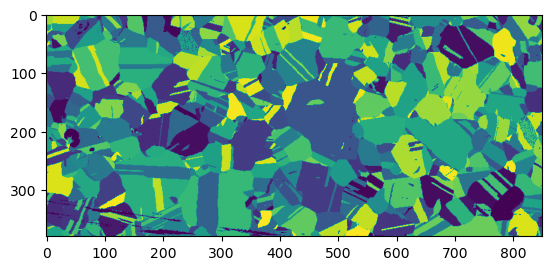

In [117]:
plt.imshow(scan.euler[:,:,0])
#plt.savefig('original_test_euler.png')

In [118]:
reconstructed = np.load('out_test_reconstruction_full.npy')#.transpose(1, 2, 0)

reconstructed_quat = np.load('../ebsd_TAE_JZ/ebsd_TAE/reconstruction_full.npy')#.transpose(1, 2, 0)

In [119]:
reconstructed.shape

(380, 850, 4)

In [120]:
reconstructed_quat.shape

(380, 850, 4)

In [121]:
for x in range(reconstructed_quat.shape[0]):
    for y in range(reconstructed_quat.shape[1]):
        if reconstructed_quat[x,y,0]<0:
            reconstructed_quat[x,y,:] = -1*reconstructed_quat[x,y,:] 
    

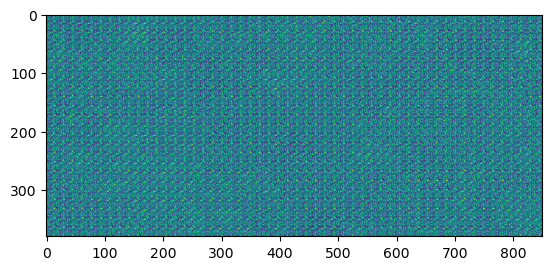

In [122]:
plt.imshow(reconstructed_quat[:,:,0])

In [123]:
og_quats = get_quats(scan)

(323000, 3)
(380, 850, 4)


In [124]:
og_quats.shape

(380, 850, 4)

In [125]:
new_euler = np.zeros((380, 850, 3))
#new_euler = np.zeros((100, 200, 3))

In [126]:
from pymicro.crystal.rotation import qu2om, om2eu

In [127]:
for i in range(380):
    for j in range(850):
        new_euler[i,j,:] = om2eu(qu2om(reconstructed_quat[i,j,:]))

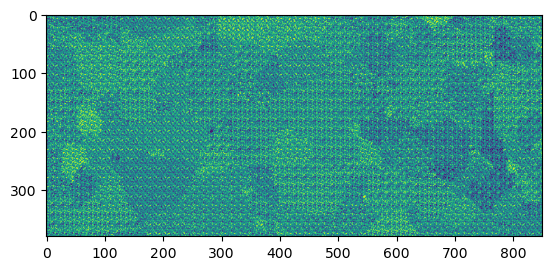

In [128]:
plt.imshow(new_euler[:,:,2])

In [129]:
100*200

20000

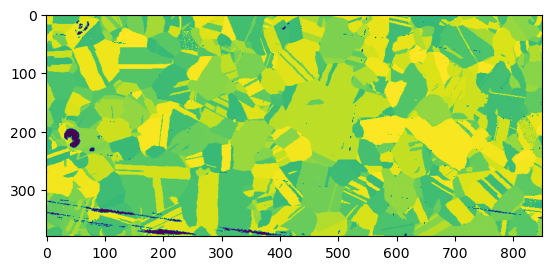

In [130]:
plt.imshow(scan.euler[:,:,2])

In [131]:
scan.euler = new_euler

In [132]:
scan.get_phase


<bound method OimScan.get_phase of EBSD scan of size 380 x 850
|- spatial resolution: x=0.5, y=0.5
|- phase 1 (Symmetry.cubic)>

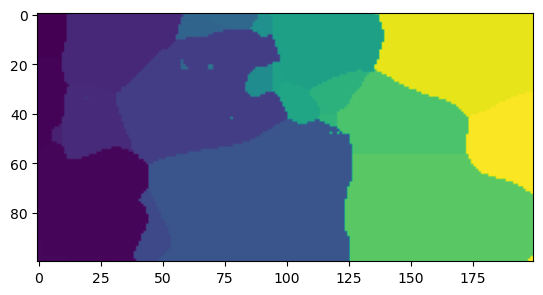

In [133]:
plt.imshow(np.load("../EBSD-map-gen/data/grains_no_twins_ids_maps/19-B590.npy")[:100,:200])

In [134]:
#reconstructed_grains_ids = scan.segment_grains(tol=5., min_ci=.5) #-0/1

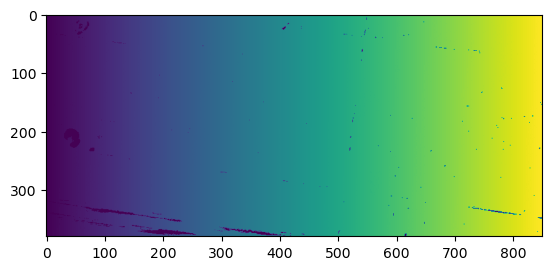

In [135]:
plt.imshow(reconstructed_grains_ids)

In [ ]:
reconstructed_grains_ids

In [ ]:
np.save('reconstructed_grains_ids_JZ.npy', reconstructed_grains_ids)

In [ ]:
reconstructed_grains_ids

# From EBSD

In [194]:
m = Microstructure.from_ebsd('data/raw_ebsd_scans/19-B590.ctf',
                             roi=[0, 380, 0, 850], grain_ids=np.load('../ebsd_TAE_JZ/ebsd_TAE/NEW_grain_map_test.npy'),)

0 phases found in the data set
new phase added: unknown
19-B590 .ctf
using ref_frame 2
symmetry was changed to Symmetry.cubic
adding phase Phase 1 (Ni-superalloy) 
	-- Lattice (Symmetry.cubic) a=0.357, b=0.357, c=0.357 alpha=90.0, beta=90.0, gamma=90.0
importing data from region [0, 380, 0, 850]
using spatial reference frame for orientation data


changing orientation reference frame progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 320084/320084 [00:19<00:00, 16428.21it/s]




0 phases found in the data set
new phase added: Ni-superalloy
using existing segmentation containing 719 grains, size is  (380, 850)





creating new grains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 719/719 [04:15<00:00,  2.81it/s]


In [155]:
micro = m
misorientations = []
for i in range(2, len(micro.grains)):
    o1 = micro.get_grain(i - 1).orientation
    o2 = micro.get_grain(i).orientation
    w = 180 / np.pi * o1.disorientation(o2)[0]
    misorientations.append(w)

# plt misorientations histogram
plt.hist(misorientations, bins=20, normed=True, cumulative=False)
plt.title('misorientation distribution, random texture %d grains' % N)
psis_dg = np.linspace(0, 63, 5 * 63 + 1)
misorientations_MacKenzie = []
for psidg in psis_dg:
    psi = np.pi * psidg / 180
    misorientations_MacKenzie.append(Orientation.misorientation_MacKenzie(psi))
plt.plot(psis_dg, misorientations_MacKenzie, 'k--', linewidth=2, label='MacKenzie (1958)')

ValueError: grain 476 not found in the microstructure

In [156]:
new_euler.shape

(380, 850, 3)

In [157]:
m.euler 

array([[[5.39458233, 2.78002152, 4.53233732],
        [5.39329777, 2.77951363, 4.53030227],
        [5.39206906, 2.78178779, 4.52710483],
        ...,
        [0.73133834, 2.37447158, 3.36373991],
        [0.73534038, 2.37446983, 3.36791997],
        [0.73078507, 2.37668989, 3.3639284 ]],

       [[5.39051572, 2.77821685, 4.52896186],
        [5.38868138, 2.78267966, 4.52728111],
        [5.39070421, 2.77840709, 4.52760923],
        ...,
        [4.8420844 , 2.48633497, 4.57682577],
        [4.84218563, 2.48849219, 4.58255568],
        [0.73376434, 2.37724665, 3.3644712 ]],

       [[5.39109517, 2.78028681, 4.52968093],
        [5.38849812, 2.78188379, 4.5247242 ],
        [5.3869919 , 2.77987491, 4.52388993],
        ...,
        [4.84604106, 2.48485144, 4.57730748],
        [4.84077016, 2.48794067, 4.5757873 ],
        [0.73149891, 2.3715499 , 3.36764595]],

       ...,

       [[3.63270387, 2.55814305, 3.32381026],
        [3.63484015, 2.56437213, 3.32112246],
        [3.62891825, 2

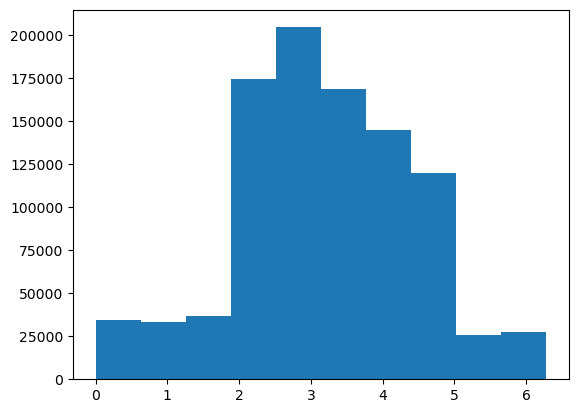

In [158]:
plt.hist(m.get_field('euler').ravel())
plt.show()

In [159]:
m.recompute_grain_bounding_boxes()

computing grain bounding boxes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 584/584 [00:00<00:00, 58041.65it/s]


array([[[  0,  32],
        [  0,  64],
        [  0,   1]],

       [[  0,  69],
        [ 36, 128],
        [  0,   1]],

       [[  0,  32],
        [ 80, 128],
        [  0,   1]],

       ...,

       [[379, 380],
        [577, 582],
        [  0,   1]],

       [[379, 380],
        [588, 592],
        [  0,   1]],

       [[379, 380],
        [837, 838],
        [  0,   1]]], dtype=int32)

In [160]:
m.recompute_grain_centers()

array([[ -88.71358, -198.1425 ,    0.     ],
       [ -77.31067, -173.09196,    0.     ],
       [ -88.42047, -159.34898,    0.     ],
       ...,
       [  94.75   ,   77.25   ,    0.     ],
       [  94.75   ,   82.5    ,    0.     ],
       [  94.75   ,  206.25   ,    0.     ]], dtype=float32)

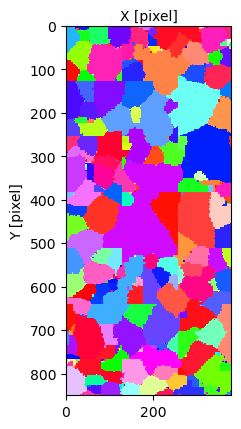

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X [pixel]', ylabel='Y [pixel]'>)

In [195]:
m.view_slice(color='ipf', axis=[1, 0, 0], show_lattices=False, unit='pixel')

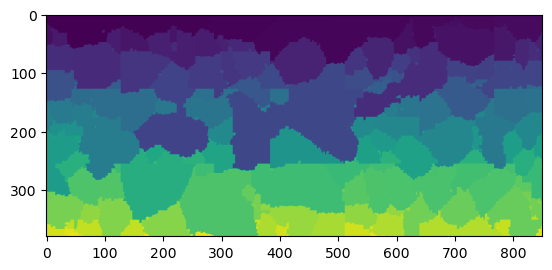

In [196]:
plt.imshow(m.get_grain_map())

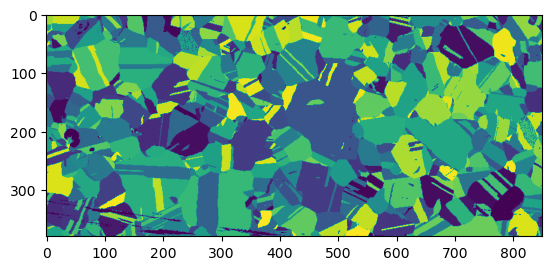

In [197]:
plt.imshow(m.euler[:,:,0])

In [198]:
np.load("../EBSD-map-gen/data/mean_quats_maps_no_twins/19-B590.npy").shape

(500, 1000, 4)

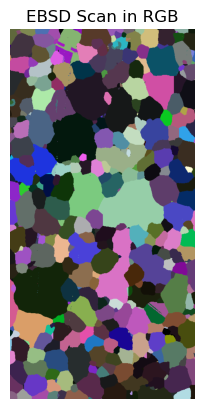

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Function to convert quaternion to Euler angles
def quaternion_to_euler(q):
    r, i, j, k = q
    ysqr = j * j

    t0 = +2.0 * (r * i + j * k)
    t1 = +1.0 - 2.0 * (i * i + ysqr)
    X = np.arctan2(t0, t1)

    t2 = +2.0 * (r * j - k * i)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = np.arcsin(t2)

    t3 = +2.0 * (r * k + i * j)
    t4 = +1.0 - 2.0 * (ysqr + k * k)
    Z = np.arctan2(t3, t4)

    return X, Y, Z

# Load the scan
scan = np.load("../EBSD-map-gen/data/mean_quats_maps_no_twins/19-B590.npy")

# Convert quaternions to Euler angles
euler_angles = np.apply_along_axis(quaternion_to_euler, -1, scan)

# Normalize Euler angles to [0, 1]
euler_norm = (euler_angles - np.min(euler_angles, axis=(0, 1))) / (np.max(euler_angles, axis=(0, 1)) - np.min(euler_angles, axis=(0, 1)))

# Convert normalized Euler angles to HSV
hsv_image = np.zeros((scan.shape[0], scan.shape[1], 3))
hsv_image[..., 0] = euler_norm[..., 0]  # H
hsv_image[..., 1] = euler_norm[..., 1]  # S
hsv_image[..., 2] = euler_norm[..., 2]  # V

# Convert HSV to RGB
rgb_image = hsv_to_rgb(hsv_image)

# Display the RGB image
plt.imshow(np.rot90(np.rot90(np.rot90(rgb_image))))
plt.title("EBSD Scan in RGB")
plt.axis('off')
plt.show()


0it [00:00, ?it/s]

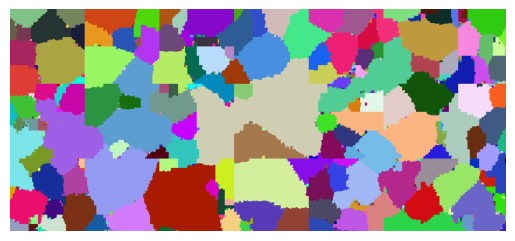

In [200]:
from itertools import product
from tqdm.notebook import tqdm

unique_ids = np.unique(m.get_grain_map())

# Create a random color for each unique ID
colors = np.random.rand(len(unique_ids), 3)  # RGB colors

# Create a dictionary to map each grain ID to a color
id_to_color = {id_: color for id_, color in zip(unique_ids, colors)}

# Create a new color map image where each pixel's ID is replaced by its corresponding color
colored_map = np.zeros((*m.get_grain_map().shape[:2], 3))  # Prepare a 3-channel RGB image
for (i,j) in tqdm(product(range(m.get_grain_map().shape[0]),
                          range(m.get_grain_map().shape[1]))):

        colored_map[i, j] = id_to_color[m.get_grain_map()[i, j, 0]]

# Display the colored map
plt.imshow(colored_map)
plt.axis('off')  # Hide axes
plt.show()

In [176]:
masks_full = np.load('../ebsd_TAE_JZ/ebsd_TAE/masks_full.npy')

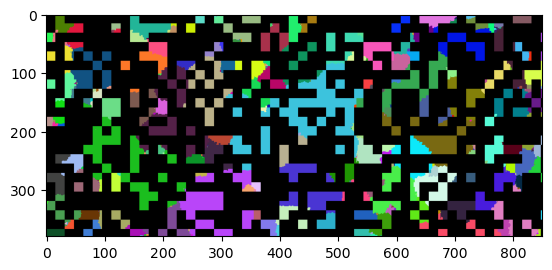

In [184]:
plt.imshow(colored_map*np.expand_dims(np.abs(masks_full-1),-1))

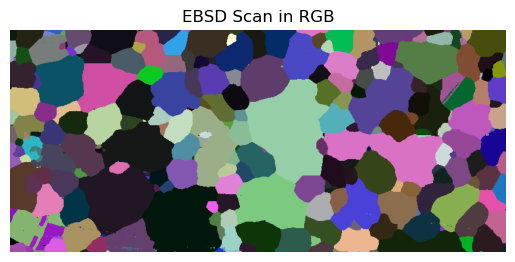

In [167]:
# Display the RGB ima
plt.imshow(rgb_image[:380,:850])
plt.title("EBSD Scan in RGB")
plt.axis('off')
plt.show()


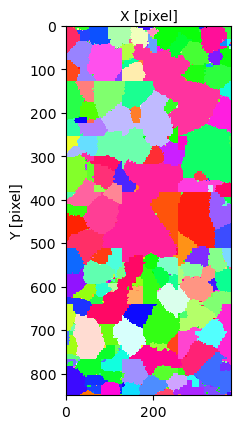

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='X [pixel]', ylabel='Y [pixel]'>)

In [168]:
m.view_slice(color='ipf', axis=[0, 0, 1], show_lattices=False, unit='pixel')

In [169]:
true_grains_ids=np.load('data/grains_no_twins_ids_maps/19-B590.npy')[:380,:850]

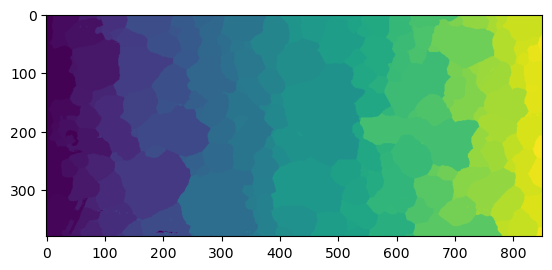

In [172]:
plt.imshow(true_grains_ids)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


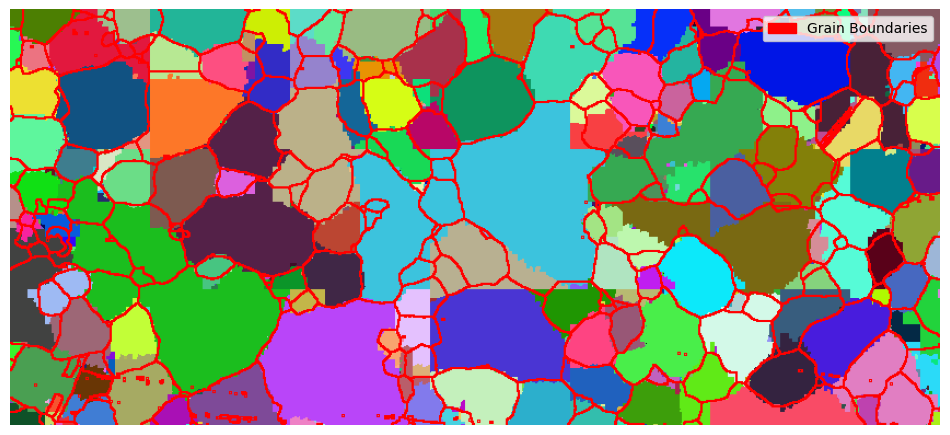

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import sobel
import matplotlib.patches as mpatches

def draw_boundaries(colored_map, true_grains_ids):
    # Calculate the gradient magnitude using Sobel operator
    grad_x = sobel(true_grains_ids, axis=0)
    grad_y = sobel(true_grains_ids, axis=1)
    grad_mag = np.hypot(grad_x, grad_y)
    
    # Create a boundary mask
    boundary_mask = grad_mag > 0
    
    # Create an RGB version of the boundary mask
    boundary_rgb = np.stack([boundary_mask]*3, axis=-1)
    
    # Overlay the boundaries on the colored map
    boundary_color = [255, 0, 0]  # Red color for boundaries
    result = np.where(boundary_rgb, boundary_color, colored_map)
    
    return result

# Example usage
result_map = draw_boundaries(colored_map, true_grains_ids)

# Display the result with increased image size, removed axis, and legend
plt.figure(figsize=(12, 8))
plt.imshow(result_map)
plt.axis('off')  # Remove axis

# Add a legend for the grain boundaries
red_patch = mpatches.Patch(color='red', label='Grain Boundaries')
plt.legend(handles=[red_patch], loc='upper right')

plt.show()


## Test on a single quaternion

In [41]:
from pymicro.crystal.ebsd import OimScan
from pymicro.crystal.lattice import Lattice, CrystallinePhase, Symmetry
from pymicro.crystal.microstructure import Microstructure
from pymicro.crystal.rotation import qu2om, om2eu
import numpy as np
from pymicro.crystal.microstructure import Orientation

dummy_quat1 = np.array([  0.40942383,   0.1862793 ,   0.77294922, -0.44042969])
dummy_quat2 = np.array([ -0.40942383,  -0.1862793 ,  -0.77294922,  0.44042969])
dummy_quat1 = np.array([ -0,  -0 ,  -0,  0])
dummy_quat2 = np.array([ -0,  -0 ,  -0,  0])


dummy_or1 = Orientation(qu2om(dummy_quat1))
dummy_or2 = Orientation(qu2om(dummy_quat2))
dummy_or1.disorientation(dummy_or2, crystal_structure=Symmetry.cubic)

(0.0, [0, 0, 0], [0, 0, 0])

In [42]:
np.rad2deg(.43)

24.6371851906254

In [ ]:
dummy_or1.disorientation(dummy_or2, crystal_structure=Symmetry.cubic)

In [ ]:
np.rad2deg(0.19354560416385916)

In [ ]:
0.19354560416385916*180/np.pi

In [ ]:
operators = Symmetry.cubic.symmetry_operators()

In [ ]:
quat_good_operators = np.array([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000],
        [ 0.7071,  0.7071,  0.0000,  0.0000],
        [ 0.7071,  0.0000,  0.7071,  0.0000],
        [ 0.7071,  0.0000,  0.0000,  0.7071],
        [ 0.7071, -0.7071,  0.0000,  0.0000],
        [ 0.7071,  0.0000, -0.7071,  0.0000],
        [ 0.7071,  0.0000,  0.0000, -0.7071],
        [ 0.0000,  0.7071,  0.7071,  0.0000],
        [ 0.0000,  0.7071,  0.0000,  0.7071],
        [ 0.0000,  0.0000,  0.7071,  0.7071],
        [ 0.0000,  0.7071, -0.7071,  0.0000],
        [ 0.0000,  0.0000,  0.7071, -0.7071],
        [ 0.0000,  0.7071,  0.0000, -0.7071],
        [ 0.5000,  0.5000,  0.5000,  0.5000],
        [ 0.5000, -0.5000, -0.5000,  0.5000],
        [ 0.5000, -0.5000,  0.5000, -0.5000],
        [ 0.5000,  0.5000, -0.5000, -0.5000],
        [ 0.5000,  0.5000,  0.5000, -0.5000],
        [ 0.5000,  0.5000, -0.5000,  0.5000],
        [ 0.5000, -0.5000,  0.5000,  0.5000],
        [ 0.5000, -0.5000, -0.5000, -0.5000]])

In [ ]:
operators[0]

In [ ]:
for i in range(operators.shape[0]):
    print('good op : ')
    print(qu2om(quat_good_operators[i]))
    print('op: ')
    print(operators[i])
    print('=================')

In [ ]:
i